In [323]:
# import librairies

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import tqdm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error
from feature_engine.selection import (DropDuplicateFeatures,
                                        DropCorrelatedFeatures,
                                        DropConstantFeatures,
                                        RecursiveFeatureElimination,
                                         RecursiveFeatureAddition)

sns.set_style("whitegrid")

In [11]:
def read_data_clf():
    df = pd.read_csv("./precleaned-datasets/dataset_2.csv")
    
    df = df[[x for x in df.columns if df[x].dtype != "object"]]
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(
        labels=["target"], axis=1), df["target"], test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [12]:
def read_data_rgr():
    df = pd.read_csv("./house-prices-advanced-regression-techniques/train.csv")
    
    df = df[[x for x in df.columns if df[x].dtype != "object"]]
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(
        labels=["SalePrice"], axis=1), df["SalePrice"], test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test

# Feature Shuffling

Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature's values, which breaks the relationship between the feature and the true outcome.

It measures the importance of a feature by calculating the increase in the model's prediction error after permuting the feature. A feature is "important" if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is "unimportant" if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction.

## Normal Method

### Classification

In [13]:
X_train, X_test, y_train, y_test = read_data_clf()

In [26]:
def run_rf(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(
        n_jobs=-1, n_estimators=100, max_depth=2, random_state=24)
    rf.fit(X_train, y_train)

    print(
        f"Train roc-auc score:{roc_auc_score(y_train,rf.predict_proba(X_train.fillna(0))[:,1])}")
    print("\n")
    print(
        f"Test roc-auc score:{roc_auc_score(y_test,rf.predict_proba(X_test.fillna(0))[:,1])}")

In [27]:
run_rf(X_train, X_test, y_train, y_test)

Train roc-auc score:0.6988469839130211


Test roc-auc score:0.6931885408438653


In [38]:
rf = RandomForestClassifier(
    n_jobs=-1, n_estimators=100, max_depth=2, random_state=24)

rf.fit(X_train, y_train)

original_performance = roc_auc_score(
    y_train, rf.predict_proba(X_train.fillna(0))[:, 1])

In [43]:
performance_decrease = []

for col in X_train.columns:

    X_train_shuffle = X_train.copy()

    X_train_shuffle[col] = X_train_shuffle[col].sample(
        frac=1, random_state=24).reset_index(drop=True)  # keep the same amount of data and dropping the index!

    new_perf = roc_auc_score(
        y_train, rf.predict_proba(X_train_shuffle.fillna(0))[:, 1])

    difference = original_performance - new_perf
    
    performance_decrease.append(difference)

In [47]:
performance_decrease = pd.Series(performance_decrease,index=X_train.columns)

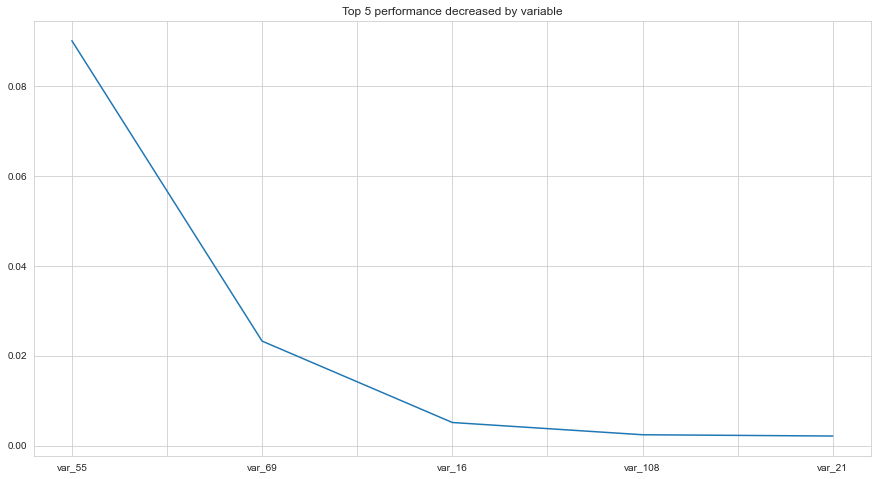

In [58]:
plt.figure(figsize=(15,8))
performance_decrease.sort_values(ascending=False)[:5].plot()
plt.title("Top 5 performance decreased by variable")
plt.show()

In [63]:
performance_decrease[performance_decrease >0].shape[0]

53

In [64]:
print(f"{performance_decrease[performance_decrease >0].shape[0]} caused a drop in performance on the RF when their values are permuted.")

53 caused a drop in performance on the RF when their values are permuted.


In [75]:
run_rf(X_train, X_test, y_train, y_test)

Train roc-auc score:0.6988469839130211


Test roc-auc score:0.6931885408438653


In [67]:
run_rf(
    X_train[performance_decrease[performance_decrease > 0].index],
    X_test[performance_decrease[performance_decrease > 0].index],
    y_train,
    y_test)

Train roc-auc score:0.6978875369332401


Test roc-auc score:0.6938712500822801


In [74]:
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(X_train[performance_decrease[performance_decrease > 0].index].shape[1]))
print('features with coefficients shrank to zero: {}'.format(
    X_train.shape[1] - X_train[performance_decrease[performance_decrease > 0].index].shape[1]))

total features: 108
selected features: 53
features with coefficients shrank to zero: 55


Close to the same score with half of the features!

### Regression

In [76]:
X_train, X_test, y_train, y_test = read_data_rgr()

In [90]:
def run_rf_rgr(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor(
        n_jobs=-1, n_estimators=100, max_depth=2, random_state=24)
    rf.fit(X_train.fillna(0), y_train)

    print(
        f"Train RMSE score:{mean_squared_error(y_train,rf.predict(X_train.fillna(0)),squared=False)}")
    print(f"Train R2 score:{r2_score(y_train,rf.predict(X_train.fillna(0)))}")
    print("\n")
    print(
        f"Test RMSE score:{mean_squared_error(y_test,rf.predict(X_test.fillna(0)),squared=False)}")
    print(f"Test R2 score:{r2_score(y_test,rf.predict(X_test.fillna(0)))}")

In [91]:
run_rf_rgr(X_train, X_test, y_train, y_test)

Train RMSE score:41559.776401676856
Train R2 score:0.7020421995079404


Test RMSE score:46261.370714704746
Test R2 score:0.7084865367767903


In [93]:
rf = RandomForestRegressor(
    n_jobs=-1, n_estimators=100, max_depth=2, random_state=24)

rf.fit(X_train.fillna(0), y_train)

original_performance_rmse = mean_squared_error(
    y_train, rf.predict(X_train.fillna(0)),squared=False)

original_performance_r2 = r2_score(
    y_train, rf.predict(X_train.fillna(0)))



performance_decrease_rmse = []
performance_decrease_r2 = []


for col in X_train.columns:

    X_train_shuffle = X_train.copy()

    X_train_shuffle[col] = X_train_shuffle[col].sample(
        frac=1, random_state=24).reset_index(drop=True)  # keep the same amount of data and dropping the index!

    new_perf_rmse = mean_squared_error(
    y_train, rf.predict(X_train_shuffle.fillna(0)),squared=False)
    
    new_perf_r2 = r2_score(
    y_train, rf.predict(X_train_shuffle.fillna(0)))

    difference_rmse = original_performance_rmse - new_perf_rmse

    difference_r2 = original_performance_r2 - new_perf_r2

    performance_decrease_rmse.append(difference_rmse)
    performance_decrease_r2.append(difference_r2)

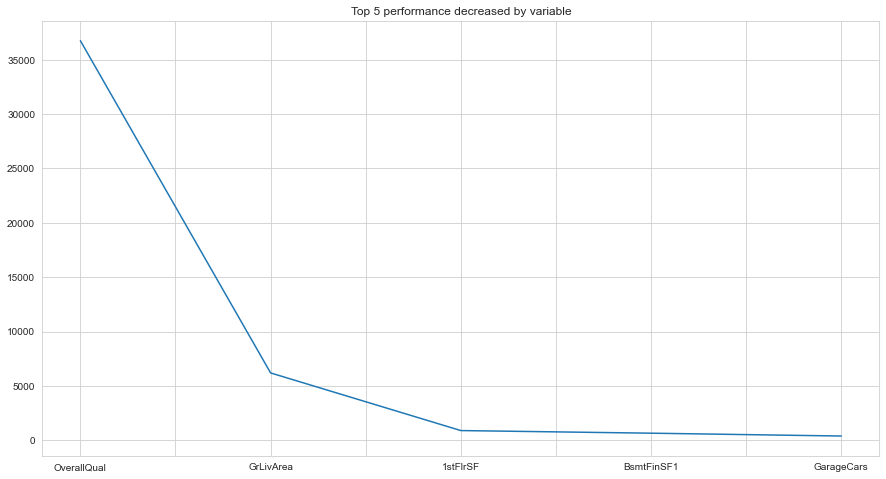

In [98]:
performance_decrease = pd.Series(performance_decrease_rmse,index=X_train.columns)
plt.figure(figsize=(15,8))
abs(performance_decrease).sort_values(ascending=False)[:5].plot()
plt.title("Top 5 performance decreased by variable")
plt.show()

In [100]:
performance_decrease[performance_decrease < 0].shape[0]

20

In [99]:
print(f"{performance_decrease[performance_decrease < 0].shape[0]} caused a drop in performance on the RF when their values are permuted.")

20 caused a drop in performance on the RF when their values are permuted.


In [102]:
run_rf_rgr(X_train, X_test, y_train, y_test)

Train RMSE score:41559.776401676856
Train R2 score:0.7020421995079404


Test RMSE score:46261.370714704746
Test R2 score:0.7084865367767903


In [104]:
run_rf_rgr(
    X_train[performance_decrease[performance_decrease < 0].index],
    X_test[performance_decrease[performance_decrease < 0].index],
    y_train,
    y_test)

Train RMSE score:41559.77640167686
Train R2 score:0.7020421995079404


Test RMSE score:46261.370714704746
Test R2 score:0.7084865367767903


In [107]:
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(X_train[performance_decrease[performance_decrease < 0].index].shape[1]))
print('features with coefficients shrank to zero: {}'.format(
    X_train.shape[1] - X_train[performance_decrease[performance_decrease < 0].index].shape[1]))

total features: 37
selected features: 20
features with coefficients shrank to zero: 17


Same performance with 17 features less!

## Feature-Engine

In [109]:
from feature_engine.selection import SelectByShuffling

### Classification

In [110]:
X_train, X_test, y_train, y_test = read_data_clf()

In [111]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=4, n_estimators=100)

In [114]:
sel_ = SelectByShuffling(
    estimator=RandomForestClassifier(n_jobs=-1, max_depth=4, n_estimators=100),
    scoring='roc_auc',
    cv=3,
    threshold=0, #Maximum perf drop allowed
    variables=None,
    random_state=24)

In [115]:
sel_.fit(X_train,y_train)

SelectByShuffling(random_state=24, threshold=0,
                  variables=['var_1', 'var_2', 'var_3', 'var_4', 'var_5',
                             'var_6', 'var_7', 'var_8', 'var_9', 'var_10',
                             'var_11', 'var_12', 'var_13', 'var_14', 'var_15',
                             'var_16', 'var_17', 'var_18', 'var_19', 'var_20',
                             'var_21', 'var_22', 'var_23', 'var_24', 'var_25',
                             'var_26', 'var_27', 'var_28', 'var_29', 'var_30', ...])

In [118]:
sel_.initial_model_performance_

0.6786463586870416

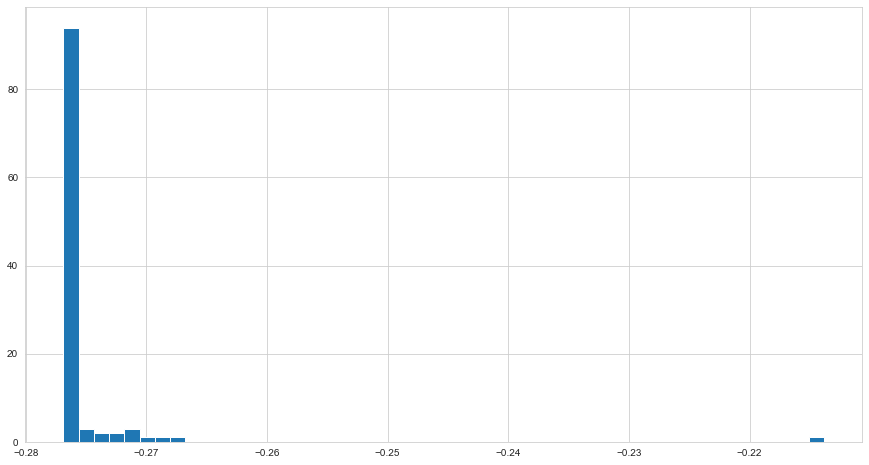

In [131]:
plt.figure(figsize=(15,8))
pd.Series(sel_.performance_drifts_).hist(bins=50)
plt.show()

In [136]:
len(sel_.features_to_drop_)

97

In [138]:
X_train = sel_.transform(X_train)
X_test = sel_.transform(X_test)

In [140]:
X_train.shape, X_test.shape

((33500, 11), (16500, 11))

In [141]:
run_rf(X_train, X_test, y_train, y_test)

Train roc-auc score:0.7009416183293355


Test roc-auc score:0.6957037421011059


Same score, less features!

### Regression

In [157]:
X_train, X_test, y_train, y_test = read_data_rgr()

In [158]:
rf = RandomForestRegressor(n_jobs=-1, max_depth=4, n_estimators=100)

In [159]:
sel_ = SelectByShuffling(
    estimator=RandomForestRegressor(n_jobs=-1, max_depth=4, n_estimators=100),
    scoring='neg_root_mean_squared_error',
    cv=3,
    threshold=0, #Maximum perf drop allowed
    variables=None,
    random_state=24)

In [160]:
sel_.fit(X_train.fillna(0),y_train)

SelectByShuffling(estimator=RandomForestRegressor(max_depth=4, n_jobs=-1),
                  random_state=24, scoring='neg_root_mean_squared_error',
                  threshold=0,
                  variables=['Id', 'MSSubClass', 'LotFrontage', 'LotArea',
                             'OverallQual', 'OverallCond', 'YearBuilt',
                             'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                             '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                             'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                             'FullBath', 'HalfBath', 'BedroomAbvGr',
                             'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                             'GarageYrBlt', 'GarageCars', 'GarageArea',
                             'WoodDeckSF', 'OpenPorchSF', ...])

In [161]:
sel_.initial_model_performance_

-36702.18960154462

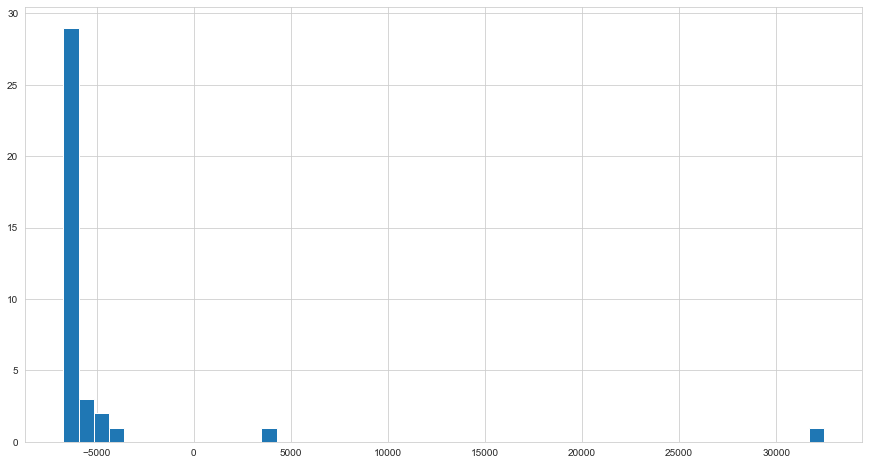

In [162]:
plt.figure(figsize=(15,8))
pd.Series(sel_.performance_drifts_).hist(bins=50)
plt.show()

In [163]:
len(sel_.features_to_drop_)

33

In [169]:
sel_.features_to_drop_[:5] # Sample

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond']

In [164]:
run_rf_rgr(X_train, X_test, y_train, y_test)

Train RMSE score:41559.776401676856
Train R2 score:0.7020421995079404


Test RMSE score:46261.37071470474
Test R2 score:0.7084865367767903


In [165]:
X_train = sel_.transform(X_train)
X_test = sel_.transform(X_test)

In [166]:
X_train.shape, X_test.shape

((978, 4), (482, 4))

In [167]:
run_rf_rgr(X_train, X_test, y_train, y_test)

Train RMSE score:42046.58000173367
Train R2 score:0.6950211597312153


Test RMSE score:46763.77862439736
Test R2 score:0.7021203633182854


Close to the same performance with less features! 

# Feature Recursive Elimination

In [170]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s coef_ or feature_importances_ attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model.

It works in the following order:
* Create a ML model with all the features and rank them by the most important to the least important.
* Remove the least important feature and create a new ML model and calculate the performance metric.
* If the metric decreased by more than an abritrary threshold, then the feature should be kept.
* Repeat step 1 and 2 with the rest of the features.

## Normal Method

### Classification

In [217]:
X_train, X_test, y_train, y_test = read_data_clf()

In [224]:
model = DecisionTreeClassifier(max_depth=4, random_state=24)

In [225]:
model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=24)

In [226]:
print(f"Train roc-auc score:{roc_auc_score(y_train,model.predict_proba(X_train.fillna(0))[:,1])}")
print("\n")
print(f"Test roc-auc score:{roc_auc_score(y_test,model.predict_proba(X_test.fillna(0))[:,1])}")

Train roc-auc score:0.7011789182352524


Test roc-auc score:0.6923358305358083


In [227]:
roc = roc_auc_score(y_test,model.predict_proba(X_test.fillna(0))[:,1])

In [228]:
feature_importance = pd.Series(
    model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

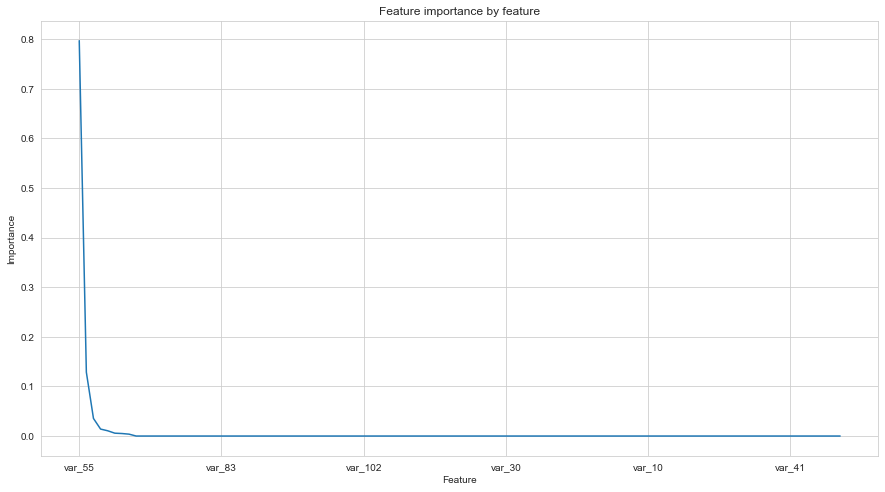

In [229]:
plt.figure(figsize=(15,8))
feature_importance.plot().bar
plt.title("Feature importance by feature")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [233]:
np.random.shuffle(feature_importance)

tol = 0.0005

feature_to_remove = []

for feature in feature_importance[:30].index: #Using a sample to speed up the process

    X_train_recursive = X_train.copy()
    X_test_recursive = X_test.copy()

    X_train_recursive = X_train_recursive.drop(
        labels=[feature] + feature_to_remove, axis=1)
    X_test_recursive = X_test_recursive.drop(
        labels=[feature] + feature_to_remove, axis=1)
    

    model_int = DecisionTreeClassifier(max_depth=4, random_state=24)

    model_int.fit(X_train_recursive.fillna(0), y_train)
    
    roc_int = roc_auc_score(y_test,model_int.predict_proba(X_test_recursive.fillna(0))[:,1])
    
    diff = roc - roc_int
    
    if diff < tol:
        
        roc_full = roc_int
        feature_to_remove.append(feature)
        

In [243]:
X_train[[x for x in feature_importance.index if x not in feature_to_remove]].head()

,var_55,var_16,var_60,var_82,var_85,var_84,var_8,var_108,var_107,var_106,...,var_43,var_42,var_41,var_40,var_39,var_38,var_37,var_36,var_35,var_109
23990,2.002787,0.0,1.098373,1.884118,4.955921,2.723684,0.584105,1.299780,1.686957,1.783113,...,1.371637,4.591175,14.219526,8.069152,5.917667,6.487244,4.256766,9.298727,5.991522,0.965991
8729,0.972343,0.0,3.519718,1.639701,4.670524,2.641323,0.756977,0.503283,2.924444,0.890909,...,4.407229,0.043653,13.800001,7.532231,0.030892,9.049161,6.259549,6.111613,7.418181,2.241669
3451,0.169202,0.0,2.062755,1.935365,5.400635,1.197885,0.276806,1.819694,1.256104,1.340006,...,2.734220,0.453945,14.345597,7.924287,0.485147,9.351721,8.563623,6.281704,9.213378,2.174361
2628,1.371931,0.0,1.656908,1.978885,8.640260,1.656526,0.531305,0.658205,0.692858,1.253192,...,2.415604,0.167784,15.544183,10.922489,0.058953,6.487781,4.935361,5.872042,4.200000,1.776894
38352,0.525097,0.0,1.240506,1.744641,5.528304,3.185301,0.673684,1.672647,0.692391,1.947771,...,2.181705,2.485241,15.097063,9.041439,5.006316,7.145949,8.662465,13.510909,8.057142,2.526562


In [244]:
model.fit(X_train[[x for x in feature_importance.index if x not in feature_to_remove]],y_train)

DecisionTreeClassifier(max_depth=4, random_state=24)

In [245]:
print(f"Train roc-auc score:{roc_auc_score(y_train,model.predict_proba(X_train[[x for x in feature_importance.index if x not in feature_to_remove]].fillna(0))[:,1])}")
print("\n")
print(f"Test roc-auc score:{roc_auc_score(y_test,model.predict_proba(X_test[[x for x in feature_importance.index if x not in feature_to_remove]].fillna(0))[:,1])}")

Train roc-auc score:0.6999966823637958


Test roc-auc score:0.6945343355055292


Close to the same score with less features!

### Regression

In [270]:
X_train, X_test, y_train, y_test = read_data_rgr()

In [271]:
X_train.shape[1]

37

In [272]:
model = DecisionTreeRegressor(max_depth=4, random_state=24)

In [273]:
model.fit(X_train.fillna(0),y_train)

DecisionTreeRegressor(max_depth=4, random_state=24)

In [274]:
print(f"Train r2 score:{r2_score(y_train,model.predict(X_train.fillna(0)))}")
print("\n")
print(f"Test r2 score:{r2_score(y_test,model.predict(X_test.fillna(0)))}")

Train r2 score:0.8022834743726


Test r2 score:0.6987736407191756


In [275]:
r2_full = r2_score(y_test,model.predict(X_test.fillna(0)))

In [276]:
feature_importance = pd.Series(
    model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

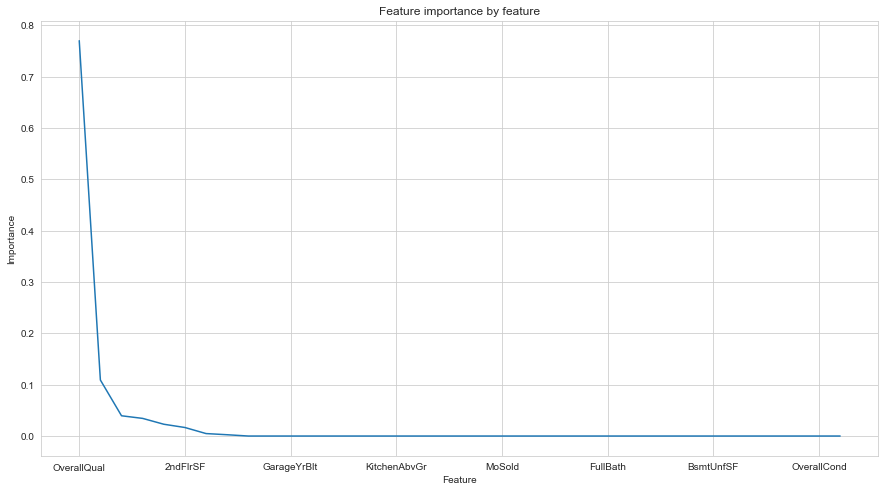

In [277]:
plt.figure(figsize=(15,8))
feature_importance.plot().bar
plt.title("Feature importance by feature")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [278]:
np.random.shuffle(feature_importance)

tol = 0.0005

feature_to_remove = []

for feature in feature_importance.index: #Using a sample to speed up the process

    X_train_recursive = X_train.copy()
    X_test_recursive = X_test.copy()

    X_train_recursive = X_train_recursive.drop(
        labels=[feature] + feature_to_remove, axis=1)
    X_test_recursive = X_test_recursive.drop(
        labels=[feature] + feature_to_remove, axis=1)
    

    model_int = DecisionTreeRegressor(max_depth=4, random_state=24)

    model_int.fit(X_train_recursive.fillna(0), y_train)
    
    r2_int = r2_score(y_test,model_int.predict(X_test_recursive.fillna(0)))
    
    diff = r2_full - r2_int
    
    if diff < tol:
        
        r2_full = r2_int
        feature_to_remove.append(feature)

In [279]:
X_train[[x for x in feature_importance.index if x not in feature_to_remove]].head()

,OverallQual,BsmtFinSF1,WoodDeckSF,2ndFlrSF,LotFrontage,LotArea,Fireplaces,GarageYrBlt,GarageCars,GarageArea,...,BsmtFullBath,LowQualFinSF,1stFlrSF,BsmtUnfSF,BsmtFinSF2,MasVnrArea,YearRemodAdd,YearBuilt,OverallCond,YrSold
615,6,763,120,0,80.0,8800,0,1963.0,2,480,...,1,0,1054,173,0,156.0,1963,1963,7,2010
613,5,206,0,0,70.0,8402,0,NaN,0,0,...,0,0,1120,914,0,0.0,2007,2007,5,2007
1303,7,0,208,0,73.0,8688,0,2005.0,3,834,...,0,0,1616,1616,0,228.0,2005,2005,5,2006
486,5,836,0,0,79.0,10289,0,1965.0,2,515,...,1,0,1073,237,0,168.0,1965,1965,7,2007
561,5,1071,240,0,77.0,10010,1,1975.0,2,418,...,1,0,1389,195,123,0.0,1975,1974,5,2006


In [280]:
model.fit(X_train[[x for x in feature_importance.index if x not in feature_to_remove]].fillna(0),y_train)

DecisionTreeRegressor(max_depth=4, random_state=24)

In [281]:
print(f"Train r2 score:{r2_score(y_train,model.predict(X_train[[x for x in feature_importance.index if x not in feature_to_remove]].fillna(0)))}")
print("\n")
print(f"Test r2 score:{r2_score(y_test,model.predict(X_test[[x for x in feature_importance.index if x not in feature_to_remove]].fillna(0)))}")

Train r2 score:0.7938102209352988


Test r2 score:0.7698413066215156


In [282]:
X_train.shape[1],X_train[[x for x in feature_importance.index if x not in feature_to_remove]].shape[1]

(37, 32)

Model with less overfitting!

## Feature-Engine

### Classification

In [305]:
X_train, X_test, y_train, y_test = read_data_clf()

In [306]:
X_train.shape[1]

108

In [307]:
pipeline = Pipeline([
    ("DropConstant", DropConstantFeatures(tol=0.998)),
    ("DropDuplicated", DropDuplicateFeatures()),
    ("DropCorrelate", DropCorrelatedFeatures()),
    ("FRE", RecursiveFeatureElimination(estimator=GradientBoostingClassifier(n_estimators=10, max_depth=2),
                                        variables=None,  # automatically evaluate all numerical variables
                                        scoring='roc_auc',  # the metric we want to evalute
                                        threshold=0.0005,  # the maximum performance drop allowed to remove a feature
                                        cv=2,  # cross-validation
                                        )
     )
])

In [308]:
model = GradientBoostingClassifier()

In [309]:
model.fit(X_train,y_train)
print(f"Train roc-auc score:{roc_auc_score(y_train,model.predict_proba(X_train.fillna(0))[:,1])}")
print("\n")
print(f"Test roc-auc score:{roc_auc_score(y_test,model.predict_proba(X_test.fillna(0))[:,1])}")

Train roc-auc score:0.7430748012683438


Test roc-auc score:0.7089665922031332


In [310]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('DropConstant',
                 DropConstantFeatures(tol=0.998,
                                      variables=['var_1', 'var_2', 'var_3',
                                                 'var_4', 'var_5', 'var_6',
                                                 'var_7', 'var_8', 'var_9',
                                                 'var_10', 'var_11', 'var_12',
                                                 'var_13', 'var_14', 'var_15',
                                                 'var_16', 'var_17', 'var_18',
                                                 'var_19', 'var_20', 'var_21',
                                                 'var_22', 'var_23', 'var_24',
                                                 'var_25', 'var_26', 'var_27',
                                                 'var_28', 'var_29', 'var_30', ...])),
                ('DropDu...
                                             estimator=GradientBoostingClassifier(max_depth=2,
      

In [311]:
pipeline.transform(X_train).shape[1]

3

In [ ]:
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

In [312]:
print(f"Train roc-auc score:{roc_auc_score(y_train,model.predict_proba(X_train.fillna(0))[:,1])}")
print("\n")
print(f"Test roc-auc score:{roc_auc_score(y_test,model.predict_proba(X_test.fillna(0))[:,1])}")

Train roc-auc score:0.7430748012683438


Test roc-auc score:0.7089665922031332


Same score but with only 3 features!

### Regression

In [313]:
X_train, X_test, y_train, y_test = read_data_rgr()

In [314]:
X_train.shape[1]

37

In [316]:
pipeline = Pipeline([
    ("DropConstant", DropConstantFeatures(tol=0.998)),
    ("DropDuplicated", DropDuplicateFeatures()),
    ("DropCorrelate", DropCorrelatedFeatures()),
    ("FRe", RecursiveFeatureElimination(estimator=GradientBoostingRegressor(n_estimators=10, max_depth=2),
                                        variables=None,  # automatically evaluate all numerical variables
                                        scoring='r2',  # the metric we want to evalute
                                        threshold=0.0001,  # the maximum performance drop allowed to remove a feature
                                        cv=3,  # cross-validation
                                        )
     )
])

In [317]:
model = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

In [318]:
model.fit(X_train.fillna(0),y_train)

GradientBoostingRegressor(max_depth=4, n_estimators=10, random_state=10)

In [319]:
print(f"Train r2 score:{r2_score(y_train,model.predict(X_train.fillna(0)))}")
print("\n")
print(f"Test r2 score:{r2_score(y_test,model.predict(X_test.fillna(0)))}")

Train r2 score:0.7632406496837609


Test r2 score:0.7050944894854375


In [320]:
pipeline.fit(X_train.fillna(0),y_train)

Pipeline(steps=[('DropConstant',
                 DropConstantFeatures(tol=0.998,
                                      variables=['Id', 'MSSubClass',
                                                 'LotFrontage', 'LotArea',
                                                 'OverallQual', 'OverallCond',
                                                 'YearBuilt', 'YearRemodAdd',
                                                 'MasVnrArea', 'BsmtFinSF1',
                                                 'BsmtFinSF2', 'BsmtUnfSF',
                                                 'TotalBsmtSF', '1stFlrSF',
                                                 '2ndFlrSF', 'LowQualFinSF',
                                                 'GrLivArea', 'BsmtFullBath',
                                                 'BsmtHalfBath', 'FullBath',
                                                 'HalfBath', 'BedroomAbvGr...
                                                        'OverallQual',
       

In [321]:
pipeline.transform(X_train).shape[1]

8

In [405]:
X_train = pipeline.transform(X_train.fillna(0))
X_test = pipeline.transform(X_test.fillna(0))

In [322]:
print(f"Train r2 score:{r2_score(y_train,model.predict(X_train.fillna(0)))}")
print("\n")
print(f"Test r2 score:{r2_score(y_test,model.predict(X_test.fillna(0)))}")

Train r2 score:0.7632406496837609


Test r2 score:0.7050944894854375


Same score with only 8 features!

# Recursive Feature Addition

Recursive feature Addition (RFA) is a feature selection method that works like RFE but in the opposite way. Instead of eliminating the worst feature, the algorithm tries to find the best features, one feature at a time.

It works in the following order:
* Create a ML model with all the features and rank them from the most important to the least important.
* Create a new ML model with only the best feature and calculate the performance metric.
* Add one feature, the best one, to the ML model and check his performance with the metric.
* If the metric increased by more than an arbitrary threshold, then the feature should be kept.
* Repeat step 1 and 2 with the rest of the features.

## Normal Method

### Classification

In [324]:
X_train, X_test, y_train, y_test = read_data_clf()

In [325]:
model = DecisionTreeClassifier(max_depth=4, random_state=24)

In [326]:
model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=24)

In [327]:
print(f"Train roc-auc score:{roc_auc_score(y_train,model.predict_proba(X_train.fillna(0))[:,1])}")
print("\n")
print(f"Test roc-auc score:{roc_auc_score(y_test,model.predict_proba(X_test.fillna(0))[:,1])}")

Train roc-auc score:0.7011789182352524


Test roc-auc score:0.6923358305358083


In [336]:
feature_importance = pd.Series(
    model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

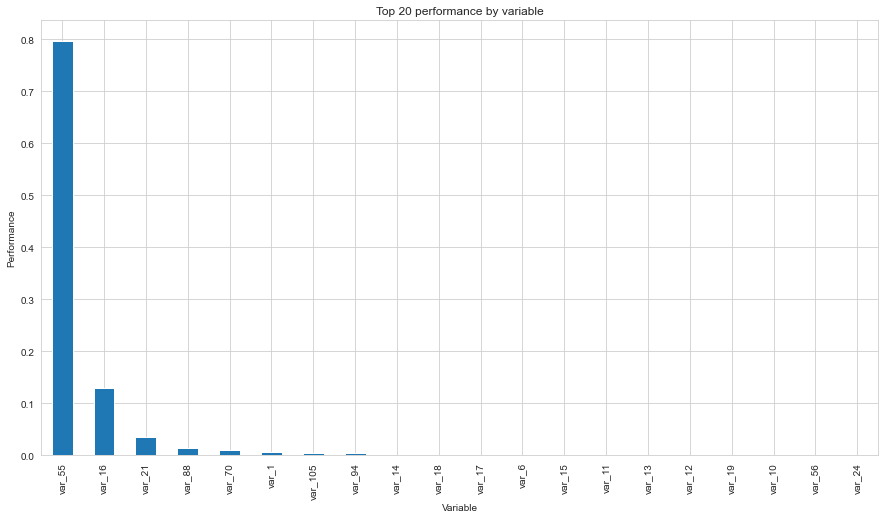

In [343]:
plt.figure(figsize=(15,8))
feature_importance.sort_values(ascending=False)[:20].plot.bar()
plt.title("Top 20 performance by variable")
plt.xlabel("Variable")
plt.ylabel("Performance")
plt.show()

In [347]:
feature_importance.index[0]

'var_55'

In [358]:
# Create model with the best  feature
model_one_feature = model.fit(X_train[feature_importance.index[0]].to_frame(), y_train)

In [360]:
# Performance with the best feature

roc_one_feature = roc_auc_score(y_test,model_one_feature.predict_proba(X_test[feature_importance.index[0]].fillna(0).to_frame())[:,1])

In [362]:
print(f"Test roc-auc score: {roc_one_feature}.")

Test roc-auc score: 0.6824487806082148.


In [370]:
tol = 0.0001

features_to_keep = [feature_importance.index[0]]

for feature in feature_importance[1:].index:

    # initialise model
    model_int = DecisionTreeClassifier(max_depth=4, random_state=24)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature]], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature]])[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)

    # determine the increase in the roc-auc
    diff_roc = roc_int - roc_one_feature

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        roc_one_feature = roc_int
        features_to_keep.append(feature)

In [371]:
X_train[features_to_keep].head()

,var_55
23990,2.002787
8729,0.972343
3451,0.169202
2628,1.371931
38352,0.525097


In [372]:
print(f"Train roc-auc score:{roc_auc_score(y_train,model.predict_proba(X_train[features_to_keep].fillna(0))[:,1])}")
print("\n")
print(f"Test roc-auc score:{roc_auc_score(y_test,model.predict_proba(X_test[features_to_keep].fillna(0))[:,1])}")

Train roc-auc score:0.6878354976617564


Test roc-auc score:0.6824487806082148


Close to the same score with only one feature!

### Regression

In [373]:
X_train, X_test, y_train, y_test = read_data_rgr()

In [374]:
X_train.shape[1]

37

In [375]:
model = DecisionTreeRegressor(max_depth=4, random_state=24)

In [376]:
model.fit(X_train.fillna(0),y_train)

DecisionTreeRegressor(max_depth=4, random_state=24)

In [377]:
print(f"Train r2 score:{r2_score(y_train,model.predict(X_train.fillna(0)))}")
print("\n")
print(f"Test r2 score:{r2_score(y_test,model.predict(X_test.fillna(0)))}")

Train r2 score:0.8022834743726


Test r2 score:0.6987736407191756


In [378]:
feature_importance = pd.Series(
    model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

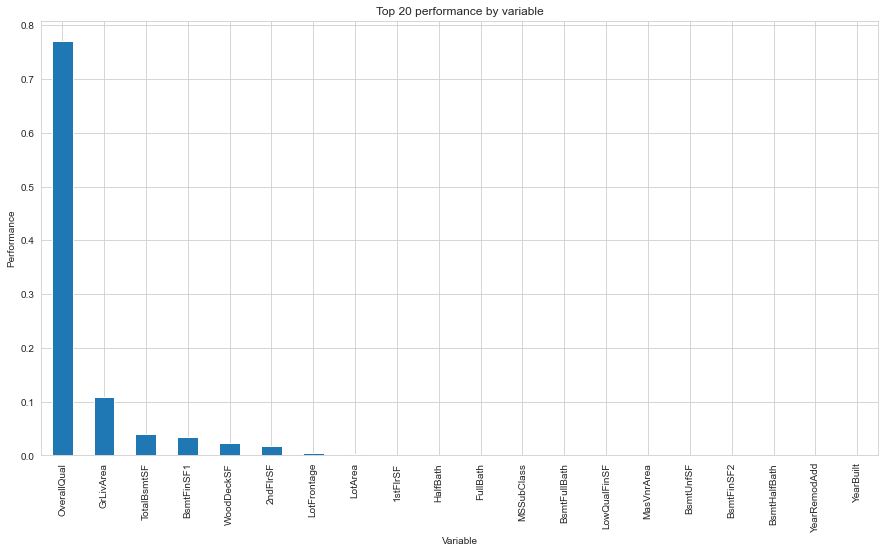

In [379]:
plt.figure(figsize=(15,8))
feature_importance.sort_values(ascending=False)[:20].plot.bar()
plt.title("Top 20 performance by variable")
plt.xlabel("Variable")
plt.ylabel("Performance")
plt.show()

In [381]:
feature_importance.index[0]
# Create model with the best  feature
model_one_feature = model.fit(
    X_train[feature_importance.index[0]].to_frame(), y_train)

# Performance with the best feature

r2_one_feature = r2_score(y_test, model_one_feature.predict(
    X_test[feature_importance.index[0]].fillna(0).to_frame()))
print(f"Test r2 score: {r2_one_feature}.")

Test r2 score: 0.6988690455776658.


In [383]:
tol = 0.0001

features_to_keep = [feature_importance.index[0]]

for feature in feature_importance[1:].index:

    # initialise model
    model_int = DecisionTreeRegressor(max_depth=4, random_state=24)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature]].fillna(0), y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict(
        X_test[features_to_keep + [feature]].fillna(0))

    # calculate the new roc-auc
    r2_int = r2_score(y_test, y_pred_test)

    # determine the increase in the roc-auc
    diff_roc = r2_int - r2_one_feature

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        r2_one_feature = r2_int
        features_to_keep.append(feature)

In [384]:
X_train[features_to_keep].head()

,OverallQual,2ndFlrSF,LotArea,Fireplaces,GarageCars
615,6,0,8800,0,2
613,5,0,8402,0,0
1303,7,0,8688,0,3
486,5,0,10289,0,2
561,5,0,10010,1,2


In [386]:
model = DecisionTreeRegressor(max_depth=4, random_state=24)

In [388]:
model.fit(X_train[features_to_keep].fillna(0),y_train)

DecisionTreeRegressor(max_depth=4, random_state=24)

In [389]:
print(f"Train r2 score:{r2_score(y_train,model.predict(X_train[features_to_keep].fillna(0)))}")
print("\n")
print(f"Test r2 score:{r2_score(y_test,model.predict(X_test[features_to_keep].fillna(0)))}")

Train r2 score:0.7667932110933451


Test r2 score:0.7987899524830595


More balanced model with fewer features!

## Feature-Engine

### Classification

In [394]:
X_train, X_test, y_train, y_test = read_data_clf()

In [395]:
X_train.shape[1]

108

In [396]:
pipeline = Pipeline([
    ("DropConstant", DropConstantFeatures(tol=0.998)),
    ("DropDuplicated", DropDuplicateFeatures()),
    ("DropCorrelate", DropCorrelatedFeatures()),
    ("FRA", RecursiveFeatureAddition(estimator=GradientBoostingClassifier(n_estimators=10, max_depth=2),
                                        variables=None,  # automatically evaluate all numerical variables
                                        scoring='roc_auc',  # the metric we want to evalute
                                        threshold=0.0001,  # the maximum performance drop allowed to remove a feature
                                        cv=2,  # cross-validation
                                        )
     )
])

In [399]:
model = GradientBoostingClassifier()

In [400]:
model.fit(X_train,y_train)
print(f"Train roc-auc score:{roc_auc_score(y_train,model.predict_proba(X_train.fillna(0))[:,1])}")
print("\n")
print(f"Test roc-auc score:{roc_auc_score(y_test,model.predict_proba(X_test.fillna(0))[:,1])}")

Train roc-auc score:0.7430748012683438


Test roc-auc score:0.7090326837315692


In [401]:
pipeline.fit(X_train.fillna(0),y_train)

Pipeline(steps=[('DropConstant',
                 DropConstantFeatures(tol=0.998,
                                      variables=['var_1', 'var_2', 'var_3',
                                                 'var_4', 'var_5', 'var_6',
                                                 'var_7', 'var_8', 'var_9',
                                                 'var_10', 'var_11', 'var_12',
                                                 'var_13', 'var_14', 'var_15',
                                                 'var_16', 'var_17', 'var_18',
                                                 'var_19', 'var_20', 'var_21',
                                                 'var_22', 'var_23', 'var_24',
                                                 'var_25', 'var_26', 'var_27',
                                                 'var_28', 'var_29', 'var_30', ...])),
                ('DropDu...
                                          estimator=GradientBoostingClassifier(max_depth=2,
         

In [402]:
pipeline.transform(X_train).shape[1]

4

In [408]:
print(f"Train roc-auc score:{roc_auc_score(y_train,pipeline.predict_proba(X_train.fillna(0))[:,1])}")
print("\n")
print(f"Test roc-auc score:{roc_auc_score(y_test,pipeline.predict_proba(X_test.fillna(0))[:,1])}")

AttributeError: 'RecursiveFeatureAddition' object has no attribute 'predict_proba'

### Regression

In [ ]:
X_train, X_test, y_train, y_test = read_data_rgr()

In [ ]:
X_train.shape[1]

In [ ]:
pipeline = Pipeline([
    ("DropConstant", DropConstantFeatures(tol=0.998)),
    ("DropDuplicated", DropDuplicateFeatures()),
    ("DropCorrelate", DropCorrelatedFeatures()),
    ("FRe", RecursiveFeatureElimination(estimator=GradientBoostingRegressor(n_estimators=10, max_depth=2),
                                        variables=None,  # automatically evaluate all numerical variables
                                        scoring='r2',  # the metric we want to evalute
                                        threshold=0.0001,  # the maximum performance drop allowed to remove a feature
                                        cv=3,  # cross-validation
                                        )
     )
])

In [ ]:
model = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

In [ ]:
model.fit(X_train.fillna(0),y_train)

In [ ]:
print(f"Train r2 score:{r2_score(y_train,model.predict(X_train.fillna(0)))}")
print("\n")
print(f"Test r2 score:{r2_score(y_test,model.predict(X_test.fillna(0)))}")

In [ ]:
pipeline.fit(X_train.fillna(0),y_train)

In [ ]:
pipeline.transform(X_train).shape[1]

In [ ]:
print(f"Train r2 score:{r2_score(y_train,model.predict(X_train.fillna(0)))}")
print("\n")
print(f"Test r2 score:{r2_score(y_test,model.predict(X_test.fillna(0)))}")